<a href="https://colab.research.google.com/github/eeuuais/analysis-stockdata-ml/blob/main/stock_price_prediction_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
!pip install pandas-datareader

In [ ]:
!pip install tensorflow

# 주가 예측
- 삼성전자 액면분할 상장일이던 2018년 5월 4일부터 2020년 1월 22일까지의 OHLVC 데이터를 이용
- 예측 종가와 실제 종가를 그래프로 그리기
- 삼성전자 2020년 2월 23일 종가 출력

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 삼성전자 데이터 불러오기
samsung = yf.download('005930.KS', start='2018-05-04', end='2020-01-22')

# MultiIndex 제거
samsung.columns = samsung.columns.droplevel(1)

# MinMaxScaler 함수 정의
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# 필요한 열 선택 및 정규화
dfx = samsung[['Open', 'High', 'Low', 'Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]

# 데이터를 리스트로 변환
x = dfx.values.tolist()
y = dfy.values.tolist()

[*********************100%***********************]  1 of 1 completed


In [ ]:
samsung

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-05-04 00:00:00+00:00,43518.378906,51900.0,53900.0,51800.0,53000.0,39565391
2018-05-08 00:00:00+00:00,44105.332031,52600.0,53200.0,51900.0,52600.0,23104720
2018-05-09 00:00:00+00:00,42679.875000,50900.0,52800.0,50900.0,52600.0,16128305
2018-05-10 00:00:00+00:00,43266.824219,51600.0,51700.0,50600.0,51700.0,13905263
2018-05-11 00:00:00+00:00,43015.277344,51300.0,52200.0,51200.0,52000.0,10314997
...,...,...,...,...,...,...
2020-01-15 00:00:00+00:00,52186.640625,59000.0,59600.0,58900.0,59500.0,14300928
2020-01-16 00:00:00+00:00,53690.332031,60700.0,60700.0,59000.0,59100.0,14381774
2020-01-17 00:00:00+00:00,54221.042969,61300.0,62000.0,61000.0,61900.0,16025661


- 숫자 단위가 클수록 계산에 소요되는 시간이 늘어나므로 OHLVC 데이터를 0-1 사이 작은 단위로 변환후 계산해 소요시간을 단축한다. 0으로 나누기 에러가 발생하지 않도록 매우작은값(1e-7)을 더해서 나눈다

In [ ]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2018-05-04 00:00:00+00:00 to 2020-01-21 00:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    420 non-null    float64
 1   High    420 non-null    float64
 2   Low     420 non-null    float64
 3   Volume  420 non-null    float64
 4   Close   420 non-null    float64
dtypes: float64(5)
memory usage: 19.7 KB


In [ ]:
dfy.info() #종가정보

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2018-05-04 00:00:00+00:00 to 2020-01-21 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   420 non-null    float64
dtypes: float64(1)
memory usage: 6.6 KB


In [ ]:
# 주식가격 x,y리스트의 마지막 부분에 저장된 값을 출력
x[-6:]

[[0.9348268839065791,
  0.9285714285677438,
  0.927565392350392,
  0.21155713424914332,
  0.9038076152268384],
 [0.898167006106321,
  0.8730158730124087,
  0.8873239436584011,
  0.1674615836301646,
  0.8637274549063578],
 [0.8818737270839841,
  0.9166666666630291,
  0.8913480885276002,
  0.16882989330989187,
  0.9318637274511749],
 [0.9959266802403425,
  0.968253968250126,
  0.9718309859115821,
  0.19665250042066781,
  0.9559118236434633],
 [0.9999999999959267,
  0.9999999999960317,
  0.9999999999959758,
  0.13746944253371812,
  0.999999999995992],
 [0.9999999999959267,
  0.9841269841230789,
  0.9798792756499803,
  0.11400880277083453,
  0.9599198396755113]]

In [ ]:
y[-6:]

[[0.9038076152268384],
 [0.8637274549063578],
 [0.9318637274511749],
 [0.9559118236434633],
 [0.999999999995992],
 [0.9599198396755113]]

In [ ]:
# 윈도우 사이즈에 따라 데이터셋 생성
# 이전 10일동안 OHLVC데이터를 이용하여 다음 날 종가를 예측하도록 데이터셋을 준비
# 이전 10일 동안 OHLVC데이터를 _x로, 다음 날의 종가를 _y로 처리
window_size = 10
data_size = 5
data_x = []
data_y = []
for i in range(len(y) - window_size):
    _x = x[i : i + window_size]  # 다음 날 종가(i+window_size)는 포함하지 않음
    _y = y[i + window_size]      # 다음 날 종가
    data_x.append(_x)
    data_y.append(_y)

In [ ]:
print(_x, "->", _y)

[[0.7433808553941206, 0.7460317460287855, 0.7545271629748308, 0.09483434069716112, 0.7354709418808197], [0.7637474541720417, 0.7857142857111677, 0.7665995975824281, 0.323174686971615, 0.7755511022013004], [0.8533604887948947, 0.8333333333300265, 0.8269617706204146, 0.33335345138624783, 0.8476953907781655], [0.8696537678172315, 0.8769841269806469, 0.8631790744432065, 0.19622106804249292, 0.8837675350665981], [0.9022403258619053, 0.8888888888853615, 0.8953722333967993, 0.117672127572782, 0.9038076152268384], [0.9348268839065791, 0.9285714285677438, 0.927565392350392, 0.21155713424914332, 0.9038076152268384], [0.898167006106321, 0.8730158730124087, 0.8873239436584011, 0.1674615836301646, 0.8637274549063578], [0.8818737270839841, 0.9166666666630291, 0.8913480885276002, 0.16882989330989187, 0.9318637274511749], [0.9959266802403425, 0.968253968250126, 0.9718309859115821, 0.19665250042066781, 0.9559118236434633], [0.9999999999959267, 0.9999999999960317, 0.9999999999959758, 0.13746944253371812

- 이전 10일동안 OHLVC 데이터 중 가장 마지막 날 종가는 0.999999999995992
- 10일 동안의 OHLVC 데이터에 매핑되는 다음 날 종가는 0.9599198396755113

In [ ]:
# 데이터셋 분할
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

In [ ]:
# 모델 생성
model = Sequential() # 시퀀셜 모델 객체 생성
model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=(window_size, data_size))) # LSTM층 추가
model.add(Dropout(0.1))
model.add(LSTM(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1)) # 유닛이 하나인 출력층을 추가
model.summary()

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error') # adam 최적화, 손실함수는 평균제곱오차(MSE)
model.fit(train_x, train_y, epochs=60, batch_size=30) # 모델 학습 / batch_size는 한번에 제공되는 훈련데이터 개수
pred_y = model.predict(test_x)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 10)              │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,491 (5.82 KB)

 Trainable params: 1,491 (5.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1073
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0873
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0759
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0618
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0351
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164
Epoch 7/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088
Epoch 8/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082
Epoch 9/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079
Epoch 10/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072
Epoch 11/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067
Epoch 12/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 13/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080
Epoch 14/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063
Epoch 15/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068
Epoch 16/60
10/

- epoch 횟수가 증가할 수록 손실함수 결괏값(loss)이 줄어든다.
- 60번째 훈련 이후에는 손실함수의 결괏값이 그다지 줄어들지 않는 것으로 봐서 학습이 완료되었다고 봐도 된다.

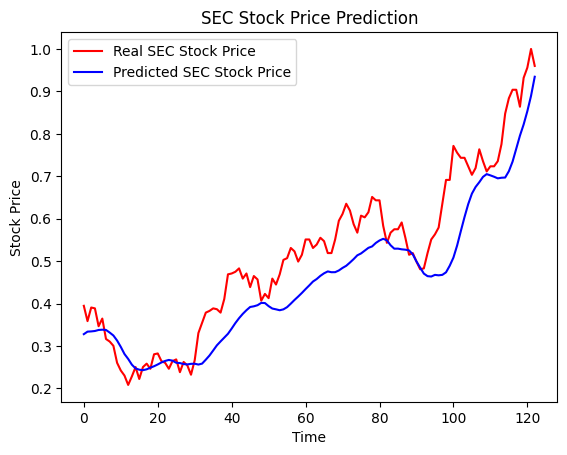

In [ ]:
# 결과 시각화
plt.figure()
plt.plot(test_y, color='red', label='Real SEC Stock Price')
plt.plot(pred_y, color='blue', label='Predicted SEC Stock Price')
plt.title('SEC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

- 파란색으로 표시한 예측치와 빨간색으로 표시한 실제 종가 사이에 별 차이가 없다.

In [ ]:
# 내일의 주가 예측
print("Tomorrow's SEC price:", samsung['Close'].iloc[-1] * pred_y[-1] / dfy['Close'].iloc[-1], 'KRW')

Tomorrow's SEC price: [59770.785] KRW


In [ ]:
# 실제 주가

actual = yf.download('005930.KS', '2020-01-23')
actual

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,005930.KS,005930.KS,005930.KS,005930.KS,005930.KS,005930.KS
Date,,,,,,
2020-01-23 00:00:00+00:00,53778.773438,60800.0,61800.0,60700.0,61800.0,14916555
2020-01-28 00:00:00+00:00,52009.746094,58800.0,59400.0,58300.0,59400.0,23664541
2020-01-29 00:00:00+00:00,52275.093750,59100.0,59700.0,58800.0,59100.0,16446102
2020-01-30 00:00:00+00:00,50594.503906,57200.0,58800.0,56800.0,58800.0,20821939
2020-01-31 00:00:00+00:00,49886.894531,56400.0,58400.0,56400.0,57800.0,19749457
...,...,...,...,...,...,...
2024-10-30 00:00:00+00:00,59100.000000,59100.0,59800.0,58600.0,59100.0,19838511
2024-10-31 00:00:00+00:00,59200.000000,59200.0,61200.0,58300.0,58500.0,35809196


60800 - 59770

약 1,030원 차이